In [1]:
import logging

logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%d-%b-%y %H:%M:%S',
                    level=logging.INFO
                   )

logging.info('Importing standard python libraries')
from pathlib import Path

logging.info('Importing third party python libraries')
import numpy as np
import xarray as xr
import xmitgcm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
from matplotlib import colors, rc
import cmocean.cm as cmo
import f90nml
import pvcalc

09-Jul-22 11:49:19 - Importing standard python libraries
09-Jul-22 11:49:19 - Importing third party python libraries


In [2]:
logging.info('Setting paths')
base_path = Path('/work/n01/n01/fwg/irminger-proj')
raw_path = base_path / 'data/raw'
processed_path = base_path / 'data/processed'
figure_path = base_path / 'figures'

run_path = raw_path / '2d-models/run'

09-Jul-22 11:49:49 - Setting paths


In [3]:
logging.info('Reading in model parameters from the namelist')
with open(run_path / 'data') as data:
    data_nml = f90nml.read(data)

delta_t = data_nml['parm03']['deltat']
f0 = data_nml['parm01']['f0']
beta = data_nml['parm01']['beta']
no_slip_bottom = data_nml['parm01']['no_slip_bottom']
no_slip_sides = data_nml['parm01']['no_slip_sides']


logging.info('Reading in the model dataset')
ds = xmitgcm.open_mdsdataset(str(run_path),
                             prefix=['ZLevelVars', 'IntLevelVars'],
                             delta_t=delta_t,
                             geometry='cartesian')

09-Jul-22 11:49:49 - Reading in model parameters from the namelist
09-Jul-22 11:49:49 - Reading in the model dataset
/mnt/lustre/a2fs-work1/work/n01/n01/fwg/dwbc-proj/dwbc-proj/lib/python3.8/site-packages/xmitgcm/mds_store.py:913: UserWarning: Couldn't find available_diagnostics.log in /work/n01/n01/fwg/irminger-proj/data/raw/2d-models/run or /work/n01/n01/fwg/irminger-proj/data/raw/2d-models/run. Using default version.
  warnings.warn("Couldn't find available_diagnostics.log "


In [5]:
logging.info('Calculating the potential vorticity')
grid = pvcalc.create_xgcm_grid(ds)
ds['drL'] = pvcalc.create_drL_from_dataset(ds)
ds['rho'] = pvcalc.calculate_density(ds['RHOAnoma'], ds['rhoRef'])
ds['b'] = pvcalc.calculate_buoyancy(ds['rho'])

ds['db_dx'], ds['db_dy'], ds['db_dz'] = pvcalc.calculate_grad_buoyancy(ds['b'], ds, grid)
ds['db_dz'] = ds['db_dz'] * xr.where(grid.interp(ds['maskC'], ['Z'], to={'Z': 'right'}, boundary='fill') == 0, np.nan, 1)

ds['zeta_x'], ds['zeta_y'], ds['zeta_z'] = pvcalc.calculate_curl_velocity(ds['UVEL'],
                                                                          ds['VVEL'],
                                                                          ds['WVEL'],
                                                                          ds,
                                                                          grid,no_slip_bottom,
                                                                          no_slip_sides
                                                                         )

ds['maskQ'] = grid.interp(ds['maskW'], ['Y', 'Z'], to={'Z': 'right', 'Y': 'left'}, boundary='fill')
ds['Q'] = pvcalc.calculate_C_potential_vorticity(ds['zeta_x'],
                                                 ds['zeta_y'],
                                                 ds['zeta_z'],
                                                 ds['b'],
                                                 ds,
                                                 grid,
                                                 beta,
                                                 f0
                                                 ) * xr.where(ds['maskQ'] == 0, np.nan, 1)

09-Jul-22 11:49:59 - Calculating the potential vorticity


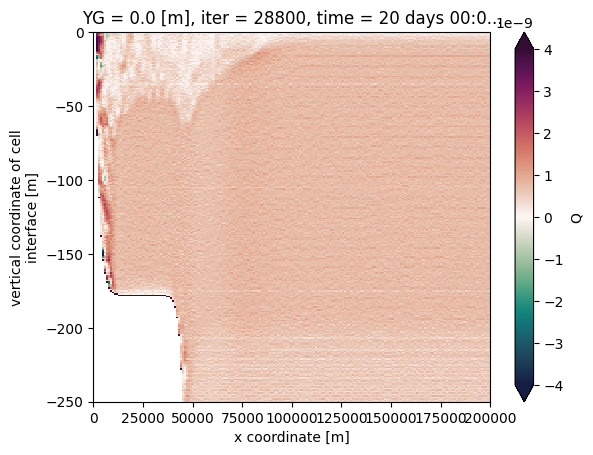

In [23]:
clim = 4e-9
tdays = 20
ds['Q'].sel(time=np.timedelta64(tdays, 'D'), method='nearest').squeeze().plot(vmin=-clim, vmax=clim, cmap=cmo.curl)
#ds['rho'].sel(time=np.timedelta64(tdays, 'D'), method='nearest').squeeze().plot.contour(vmin=1026.5, vmax=1027.5, levels=20, cmap=cmo.dense)
plt.ylim(-250, 0)
plt.xlim(0, 200e3)
plt.show()

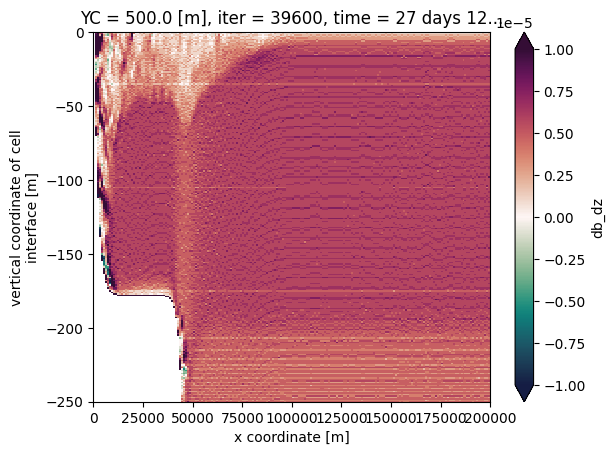

In [31]:
tdays=28
ds['db_dz'].sel(time=np.timedelta64(tdays, 'D'), method='nearest').squeeze().plot(vmin=-1e-5, vmax=1e-5, cmap=cmo.curl)
plt.ylim(-250, 0)
plt.xlim(0, 200e3)
plt.show()